In [1]:
import networkx as nx
import import_ipynb
import h2_ENb_gen as h2
import h1_ENB_occ as h1
import g1_generate_dictionary as g1
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import pandas as pd
import pycountry
import numpy as np
import random 
import networkx.algorithms.community
import community
from community import community_louvain


importing Jupyter notebook from h2_ENb_gen.ipynb
importing Jupyter notebook from c1_extract_paragraphe_issue.ipynb
Issue  34
importing Jupyter notebook from c2_extract_sentence_issue.ipynb
importing Jupyter notebook from g1_generate_dictionary.ipynb
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
importing Jupyter notebook from h1_ENB_occ.ipynb


In [2]:
# Dictionary for each COP (key) with the issues related to it (values)
dict_cop = {1: np.arange(12,22),
            2: np.arange(29,38),
            3: np.arange(68,76),
             4: np.arange(88,97),
             5 : np.arange(113,123),
             6: np.arange(153,163),
             7: np.arange(179,189),
             8: np.arange(200,209),
             9: np.arange(222,230),
             10: np.arange(250,260),
             11: np.arange(281,291),
             12: np.arange(308,318),
             13: np.arange(344,354),
             14: np.arange(386,395),
             15: np.arange(449,459),
             16: np.arange(488,497),
             17: np.arange(524,534),
             18: np.arange(557,567),
             19: np.arange(584,593),
             20 : np.arange(609,619),
             21: np.arange(653,663),
             22: np.arange(679,689),
             23: np.arange(704,714),
             24: np.arange(736,747),
             25: np.arange(765,774)}

In [3]:
def create_dict():
    DICTIONARY = g1.compute_dictionary()
    n = 0
    DICTIONARY_NUM = dict()
    for k in DICTIONARY:

        DICTIONARY_NUM[n] = k
        n +=1
    NAMES = []
    for x in DICTIONARY.values():
        if(len(x) == 1):
            NAMES.append(x[0])

        else:
            NAMES += [k for k in x]
    return DICTIONARY, DICTIONARY_NUM, NAMES

In [4]:
def  extract_df_cop1(cooperation,issue_cop):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h1.extract_relationships_count(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue','behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped


In [5]:
def extract_df_cop(issue_cop, cooperation):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h2.interactions(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue','behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped

In [40]:
def graph_cop(df_cop, direct):
    """Create the directed weighted graph from the dataframe. """
    if(direct):
        G=nx.DiGraph()
        print('bof')
    else :
        G = nx.Graph()
    #Creates nodes
    nodes =  list(set(list(df_cop['id_ca'].to_numpy()) + list(df_cop['id_cb'].to_numpy())))
    G.add_nodes_from(nodes)
    # Create edges
    edges = list(zip(df_cop['id_ca'], df_cop['id_cb']))
    G.add_edges_from(edges)
     # Create weights of the edges
    df_edges = df_cop.drop(['Country A','Country B'], axis = 1)
    list_weigths = list(df_edges.to_records(index = False))
    G.add_weighted_edges_from(list_weigths)
    
    return G, list_weigths

In [68]:
def plot_graph(G, issue_cop):
    """Plot the directed weighted graph from the dataframe. """
    pos = nx.spring_layout(G, k=2.5)
    figsize = (20,10)
    fig, axe = plt.subplots(1, 1, figsize=figsize)
    s = ""
    plt.title(s, fontsize=18)
    names = dict([(n,DICTIONARY_NUM[n]) for n in G.nodes])
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    labels=nx.draw_networkx_labels(G,pos=pos, labels= names,font_size = 15 ,font_color = 'k',font_weight='bold')
    nx.draw(G, pos = pos, edges=edges, edge_color='grey', node_size=10, node_color ='k',width = weights)

In [69]:
DICTIONARY, DICTIONARY_NUM, NAMES = create_dict()

### Find the node centrality for each node
In a connected graph, the normalized closeness centrality (or closeness) of a node is the average length of the shortest path between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.

def centrality(dict_cent, x):
    if(x in dict_cent):
        return dict_cent[x]
    else :
        return 0

def compute_centrality_COP(cop_number,top_n, print_top):

    #Create dataframe with nodes and centrality for first COP 
    df_nodes = pd.DataFrame()
    df_nodes['id_c'] = list(DICTIONARY_NUM.keys())
    df_nodes['Country'] = df_nodes['id_c'].apply(lambda x : DICTIONARY_NUM[x])

    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop = graph_cop(df_cop, False)
    cent_deg_dict = nx.degree_centrality(G_cop)
    cent_s = 'centrality COP'+str(cop_number)
    df_nodes[cent_s] = df_nodes['id_c'].apply(lambda x : centrality(cent_deg_dict, x))
    
    if(print_top):
        df_cent = df_nodes.drop(['id_c'], axis = 1)
        list_top = sorted(list(df_cent.to_records(index = False)),key=lambda item: item[1],reverse = True)[:top_n]

        fmt = '%-45s%s'
        print("\nTop "+str(top_n)+" countries with biggest centrality score\n")
        print(fmt % ('- Country -', '- Centrality score- '))
        for i, (high, low) in enumerate(list_top):
            print(fmt % (high, low))

    return df_nodes

### Louvain modularity
The Louvain method for community detection is a method to extract communities from large networks

def communities_cop(G_cop):
    partition = community_louvain.best_partition(G_cop)
    
    for i in set(partition.values()):
        print('Community '+str(i+1)+'\n')
        for k in partition:
            if(partition[k] == i):
                print(DICTIONARY_NUM[k])
        print('\n----------------------------------------')
    return partition

#### Notes
Umbrella Group : same community as AOSIS twice (small community) 

Switzerland : same community as EIG, Japan, Norway, New Zealand, United States, Canada, EU, Australia, Turkey (bigger community)


### PageRank
PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results.

PageRank is a way of measuring the importance of website pages. According to Google: PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is.

In [55]:
def pageRank_COP(cop_number, top_n, print_top) :
    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop, list_weights = graph_cop(df_cop, True)
    pr = nx.pagerank(G_cop)
    
    if(print_top):
        pr_sorted = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1],reverse = True)}
        top_c = [(k,v) for k,v in pr_sorted.items()][:top_n]
        list_top = []
        for c in top_c:
            list_top.append((DICTIONARY_NUM[c[0]],c[1]))


        fmt = '%-45s%s'
        print("\nTop "+str(top_n)+" countries with biggest pagerank score\n")
        print(fmt % ('- Country -', '- PageRank score- '))
        for i, (high, low) in enumerate(list_top):
            print(fmt % (high, low))

    return pr

### Degree distribution

import collections
from scipy.stats import pareto
def node_degree_distribution(G_cop, slope):
    degree_sequence = sorted([d for n, d in G_cop.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    max_deg = degree_sequence[0]
    max_num = cnt[0]
    min_deg = degree_sequence[-1]
    min_num = cnt[-1]

    """Plot the distribution of node degrees"""
    figsize = (20,10)
    fig, axe = plt.subplots(1, 1, figsize=figsize)

    plt.plot(deg,cnt, marker='o')

    plt.title("Node degree distribution")
    plt.ylabel("number of nodes")
    plt.xlabel("degree range")
     
    plt.show()

    return max_deg, max_num, min_deg, min_num

### Find neighbors of member EIG

issues_cop = dict_cop[20]
df_cop = extract_df_cop(issues_cop, True)

In [75]:
#some_values = ['SWITZERLAND','MEXICO','LIECHTENSTEIN','MONACO','GEORGIA','REPUBLIC OF KOREA']
df_CH = df_cop20.loc[df_cop20['Country A'].isin(['CHINA'])]
#df_CH = pd.concat([df_cop20.loc[df_cop20['Country A'].isin(some_values)],df_cop20.loc[df_cop20['Country B'].isin(some_values)]])
G_cop,l = graph_cop(df_CH, direct = False)

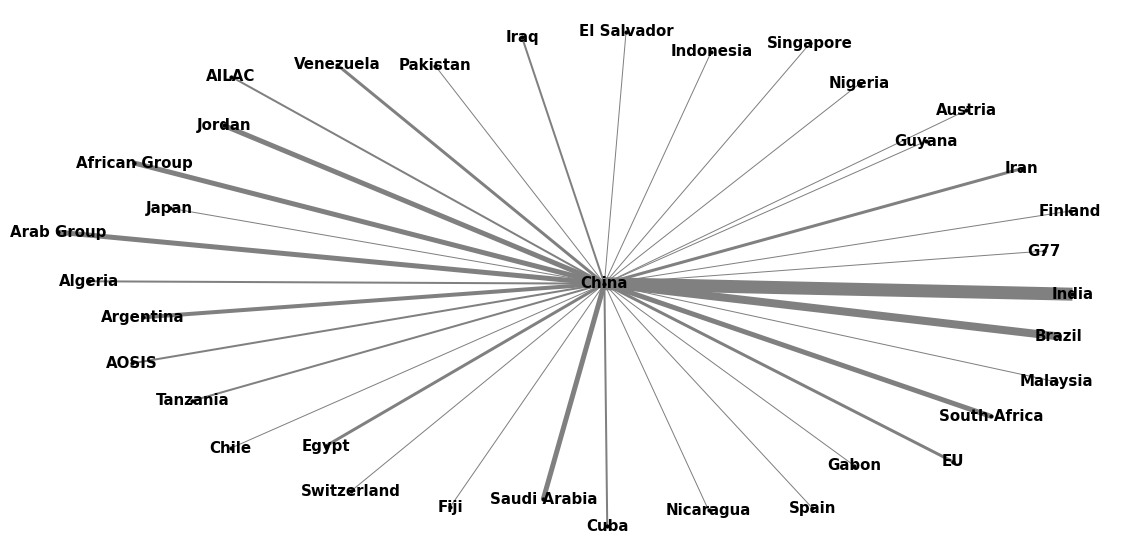

In [76]:
plot_graph(G_cop, 20)

# COP 6 

issues_cop = dict_cop[6]
df_cop6 = extract_df_cop(issues_cop, True)
G_cop6 = graph_cop(df_cop6, direct = False)

plot_graph(G_cop6, 6)

pr = pageRank_COP(6, 15, True)

df_nodes = compute_centrality_COP(6, 10, True)

max_deg, max_num, min_deg, min_num = node_degree_distribution(G_cop6,slope)

# COP 20 

In [56]:
issues_cop = dict_cop[20]
df_cop20 = extract_df_cop(issues_cop, True)
G_cop20, list_weights = graph_cop(df_cop20, direct = True)

Issue  609
Issue  610
Issue  611
Issue  612
Issue  613
Issue  614
Issue  615
Issue  616
Issue  617
Issue  618
bof


np.mean([x[1] for x in list(G_cop20.in_degree(weight='weight'))])

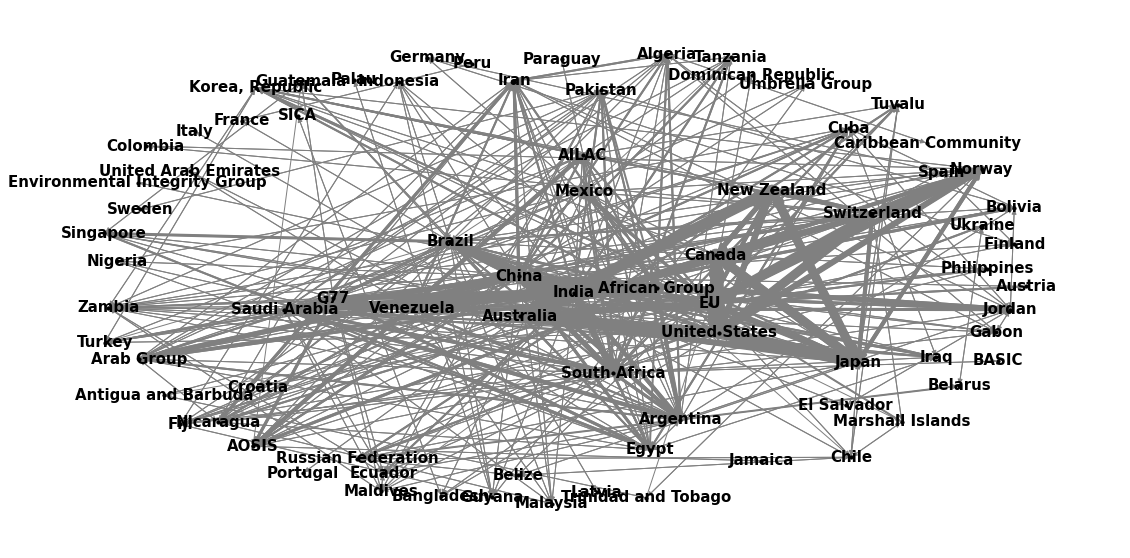

In [71]:
plot_graph(G_cop20, 20)

In [72]:
pr = pageRank_COP(20, 20, True)

Issue  609
Issue  610
Issue  611
Issue  612
Issue  613
Issue  614
Issue  615
Issue  616
Issue  617
Issue  618
bof

Top 20 countries with biggest pagerank score

- Country -                                  - PageRank score- 
China                                        0.05864910548931567
EU                                           0.055931692950863886
India                                        0.04879987640812252
United States                                0.046325437740574606
African Group                                0.03681836638343464
Brazil                                       0.03498846500121983
Japan                                        0.03217960651020299
South Africa                                 0.03202335969361431
Australia                                    0.03076046932504012
Switzerland                                  0.03035073945599518
Saudi Arabia                                 0.03014194765042498
Canada                                       0.02782664441

df_nodes = compute_centrality_COP(20, 10, True)

max_deg, max_num, min_deg, min_num = node_degree_distribution(G_cop20,slope)

# COP 21 

In [ ]:
issues_cop = dict_cop[21]
df_cop21 = extract_df_cop(issues_cop, True)
G_cop21 = graph_cop(df_cop21, direct = False)

In [ ]:
plot_graph(G_cop21, 21)

In [ ]:
pr = pageRank_COP(21, 10, True)

In [ ]:
df_nodes = compute_centrality_COP(21, 10, True)

In [ ]:
max_deg, max_num, min_deg, min_num = node_degree_distribution(G_cop21,slope)

In [ ]:
issues_cop = dict_cop[24]
df_cop24 = extract_df_cop(issues_cop, True)
G_cop24 = graph_cop(df_cop24, direct = False)

In [ ]:
plot_graph(G_cop24, 24)

In [28]:
issues_cop = dict_cop[25]
df_cop25 = extract_df_cop(issues_cop, True)
G_cop25 = graph_cop(df_cop25, direct = False)

Issue  765
Issue  766
Issue  767
Issue  768
Issue  769
Issue  770
Issue  771
Issue  772
Issue  773


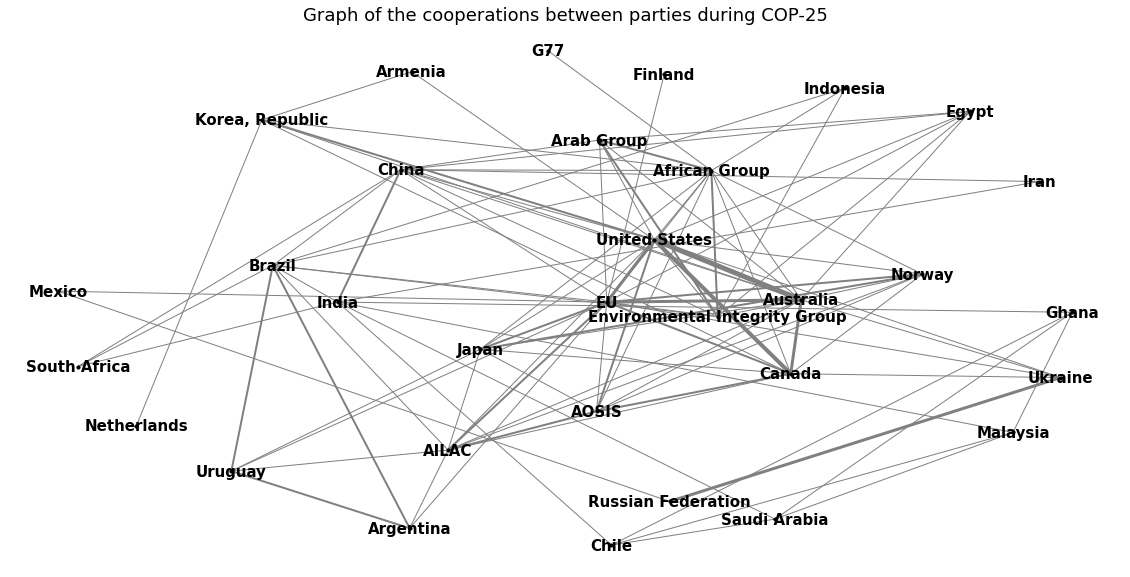

In [29]:
plot_graph(G_cop25, 25)